## <center>Определение перспективной игровой платформы для интернет-магазина</center>

### Описание проекта:

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Шаг 1. Откроем файл с данными и изучите общую информацию

##### Импорты

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

##### Датафрейм

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

Описание значений столбца 'Raiting'
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»

##### Вывод:

- Привести названия столбцов к нижнему регистру для удобства.
- Перевести столбцы 'Year_of_Release', 'Critic_Score' и 'User_Score' в целочисленный тип.
- Обработать пропуски при необходимости (предположительно возникли при выгрузке данных)
- Проверить на выбросы

### Шаг 2. Подготовим данные

Приведем названия столбцов к нижнему регистру:

In [4]:
games.columns = map(str.lower, games.columns)

Переведем необходимые столбцы в целочисленный тип:

In [5]:
games[['year_of_release', 'critic_score']] = games[['year_of_release', 'critic_score']].astype('Int64')

Столбец 'user_score' имеет значение tbd, которое означает - "To Be Determined", то есть "Будет определенно". Т.к. мы не можем логически заменить или удалить эти значение (их много) - мы заменим их на NaNы методом to_numeric, который также переведет столбец в тип float. Этот тип представляется удобным для восприятия данных в этом столбце.

In [6]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

Для замены NaNов я не нашел логического решения, а удаление отбросит большую часть данных, что может повлиять на реальную картину.

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [7]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Шаг 3. Проведем исследовательский анализ данных

##### Посмотрим, сколько игр выпускалось в разные годы:

Создадим сводную таблицу с количеством игр выпущенных за определенные года:

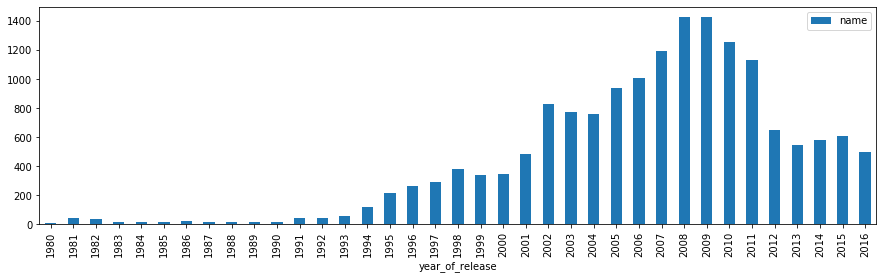

In [8]:
(games
 .pivot_table(index='year_of_release', values='name', aggfunc='count')
 .plot(kind='bar', figsize=(15, 4)));

До 1995 года вышло мало хороших игр на неактуальных, на сегодняшний день, консолях. Сделаем срез данных от 1995 года:

In [9]:
games = games.query('year_of_release >= 1995')

##### Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам:

Таблица для платформ с наибольшими суммарными продажами, распределенных по годам:

In [10]:
platform_sales = (games
 .pivot_table(index=('platform', 'year_of_release'), values='total_sales', aggfunc='sum')
 .reset_index())

Будем считать, что наибольшие суммарные продажи - те, что выше квантиля в 75%

In [11]:
#квантиль 75%
platform_sales_q75 = platform_sales['total_sales'].quantile(q=0.75)
#платфоры выше этого квантиля
platform_sales_top = platform_sales.query('total_sales >= @platform_sales_q75')
#список успешных платформ
platform_top_list = platform_sales_top['platform'].unique()

График распределения успешных игровых платформ по годам:

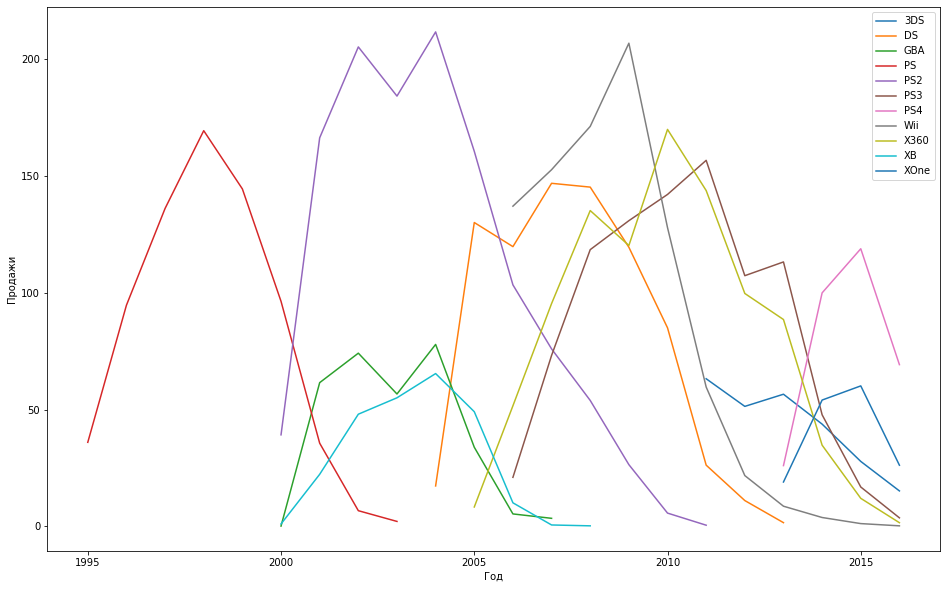

In [12]:
plt.figure(figsize=(16, 10))

for i in platform_top_list:
    x = platform_sales.query('platform == @i')['year_of_release']
    y = platform_sales.query('platform == @i')['total_sales']
    plt.plot(x, y, label=i)
    plt.xlabel("Год")
    plt.ylabel("Продажи")
    plt.legend(loc = 1)

На графике видно, что платформы "живут" примерно 7-10 лет. Компания Sony производила самые популярные консоли семейства PlayStation и уступила лидерство X360 в 2010 году, но с выходом консолей нынешнего поколения вернула первенство среди домашних консолей. 

##### Возьмем данные за соответствующий актуальный период

За актуальный период можно принять данные с 2010 по 2016 года, в который входят консоли предыдущего поколения и нынешнего.

In [13]:
#список актуальных платформ в 2016 году
platforms_in_2016 = games.query('year_of_release == 2016')['platform'].unique()
#срез по списку актульных платформ в 2016 году с 2010 года
actual_table = games.query('year_of_release >= 2010 and platform in @platforms_in_2016').reset_index()
#сводная таблица
actual_platforms = actual_table.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')

График распределения актуальных платформ с 2010 года.

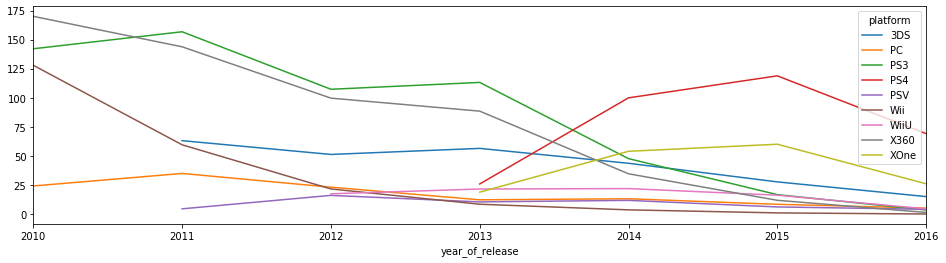

In [14]:
actual_platforms.T.plot(figsize=(16, 4))

Из графика видно, что тенденция к покупке консолей снижается. Наиболее популярные консоли в 2016 году, как и в 2015 - PS4 и XOne.

##### Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.

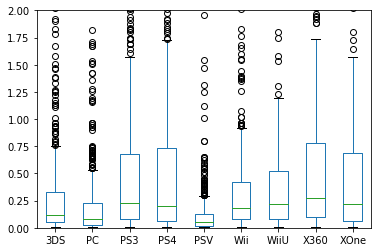

In [15]:
actual_platforms_box = actual_table.pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum')
actual_platforms_box.plot(kind='box', ylim=(0,2));

In [16]:
actual_table.groupby('platform')['total_sales'].mean().sort_values( ascending=False)

platform
X360    0.809426
PS4     0.801378
PS3     0.661125
XOne    0.645020
WiiU    0.559116
3DS     0.503535
Wii     0.495489
PC      0.254614
PSV     0.125431
Name: total_sales, dtype: float64

На графике boxplot видно, что лидируют консоли нынешнего и прошлого поколения, на PS Vita и PC меньше всего продаж. Лидером среди консолей нынешнего поколения является - PS4. 

##### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

Выберем саму популярную на сегодняшний день платформу - PS4.

In [17]:
ps4_slice = actual_table.query('platform == "PS4"')
ps4_score = pd.DataFrame(ps4_slice[['critic_score','user_score', 'total_sales']])

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


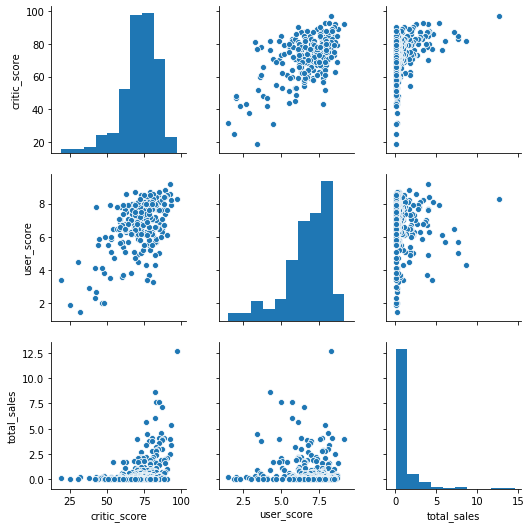

In [18]:
#pd.plotting.scatter_matrix(ps4_score) не работает
sns.pairplot(ps4_score);

In [19]:
ps4_score.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


Диаграмма размаха и корреляции показывают, что продажи на PS4 имеют среднюю зависимость от отзывов критиков и не коррелируют с отзывами пользователей. Игроки больше прислушиваются к игровыми критикам и профессиональным журналистам, нежели к игрокам, т.к. такой отзыв не объективен.

##### Соотнесем выводы с продажами игр на других платформах:

Посмотрим корреляцию еще по двум популярным игровым платформам и сравним с результатом PS4:

Корреляции для X360:

In [45]:
actual_table.query('platform == "X360"')[['critic_score','user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.597552,0.340064
user_score,0.597552,1.000000,0.066035
total_sales,0.340064,0.066035,1.000000


Корреляции для PS3:

In [47]:
actual_table.query('platform == "PS3"')[['critic_score','user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.595259,0.400594
user_score,0.595259,1.000000,0.065092
total_sales,0.400594,0.065092,1.000000


Корреляции для XOne:

In [91]:
actual_table.query('platform == "XOne"')[['critic_score','user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


Для других платформ тенденция примерно такая же, как и для PS4.

##### Посмотрим на общее распределение игр по жанрам.

In [21]:
actual_table.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

genre
Action          633.63
Shooter         477.38
Sports          313.35
Role-Playing    259.22
Misc            212.30
Racing          118.43
Platform        112.49
Fighting         76.32
Simulation       61.68
Adventure        46.90
Strategy         28.29
Puzzle           10.36
Name: total_sales, dtype: float64

Больше всего играют в игры жанра экшн и шутеры. Люди предпочитают динамичные, легкие и впечатляющие игры. Стратегии и пазлы оказались наименее прибыльными.

### Шаг 4. Составим портрет пользователя каждого региона

### Северная Америка (NA)

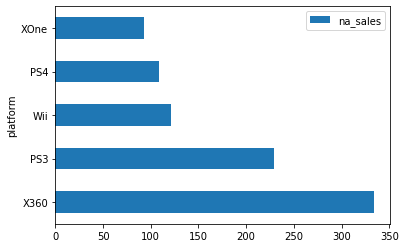

In [69]:
na_top5_platforms = (actual_table
                     .pivot_table(index='platform', values='na_sales', aggfunc='sum')
                     .sort_values(by='na_sales', ascending=False)
                     .head(5))

na_top5_platforms.plot(kind='barh');

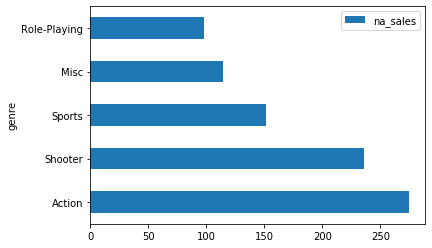

In [70]:
na_top5_genres = (actual_table
                  .pivot_table(index='genre', values='na_sales', aggfunc='sum')
                  .sort_values(by='na_sales', ascending=False)
                  .head(5))
na_top5_genres.plot(kind='barh');

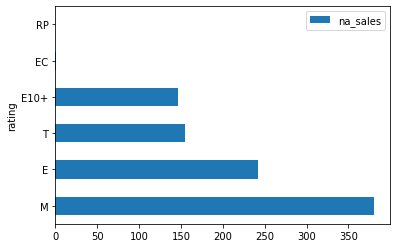

In [73]:
esrb_na = actual_table.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
esrb_na.plot(kind='barh');

##### Портрет пользователя NA региона:

- Любимая платформа - X360
- Любимый жанр - Action и Shooter
- Предпочтительный рейтинг - M (Для взрослых) и E (Для всех)

Северо-американский пользователь любит домашние консоли, в которых может потеряться после тяжелого трудового для за новой, красивой игрой в жанре Экшн или Шутер. Также заметен спрос на приставки Wii, в которых развиты игры жанра Sports.

### Европа (EU)

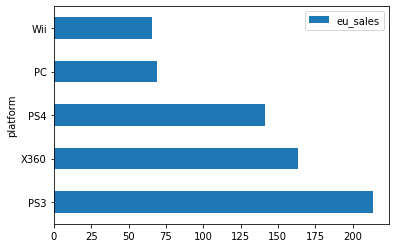

In [84]:
eu_top5_platforms = (actual_table
                     .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
                     .sort_values(by='eu_sales', ascending=False)
                     .head(5))

eu_top5_platforms.plot(kind='barh');

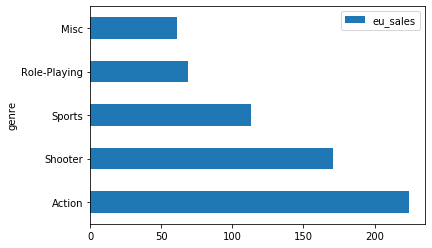

In [75]:
eu_top5_genres = (actual_table
                  .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
                  .sort_values(by='eu_sales', ascending=False)
                  .head(5))
eu_top5_genres.plot(kind='barh');

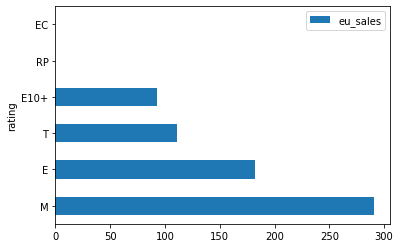

In [76]:
esrb_eu = actual_table.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
esrb_eu.plot(kind='barh');

##### Портрет пользователя EU региона:

- Любимая платформа - PS3
- Любимый жанр - Action и Shooter
- Предпочтительный рейтинг - M (Для взрослых) и E (Для всех)

EU пользователь похож на NA, с отличием в том, что больше отдает предпочтение играм жанра РПГ, а также не забывает про старый-добрый PC гейминг. 

### Япония (JP)

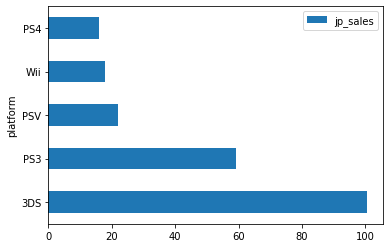

In [85]:
jp_top5_platforms = (actual_table
                     .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
                     .sort_values(by='jp_sales', ascending=False)
                     .head(5))

jp_top5_platforms.plot(kind='barh');

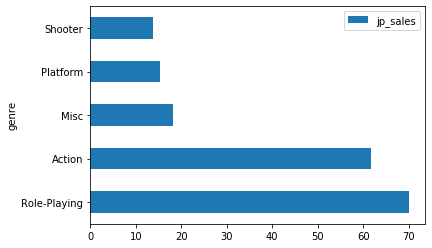

In [87]:
jp_top5_genres = (actual_table
                  .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
                  .sort_values(by='jp_sales', ascending=False)
                  .head(5))
jp_top5_genres.plot(kind='barh');

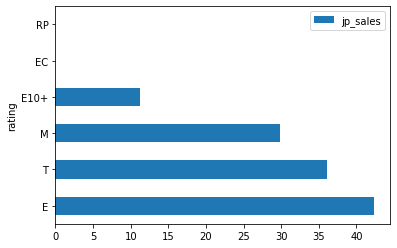

In [88]:
esrb_jp = actual_table.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
esrb_jp.plot(kind='barh');

##### Портрет пользователя JP региона:

- Любимая платформа - 3DS
- Любимый жанр - Action и Role-Playing
- Предпочтительный рейтинг - E (Для всех) и T (Подросткам)

В Японии хорошо развит портативный гейминг, когда ты можешь, ехав в поезде на работу или учебу, "убить время" до пункта назначения в удобном (для портативных приставок) жанре РПГ или Экшн.

### Шаг 5. Проверка гипотез

Проведем статистические тесты методом Стьюдента (сравнение среднего двух выборок), чтобы понять, различаются ли средние пользовательские рейтинги для платформ XBox One и PC, а также для жанров Action и Sports.

Критический уровень статистической значимости alpha примем за 0.05%

In [31]:
alpha = 0.05

### H0 = Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
H1 = Средние пользовательские рейтинги платформ Xbox One и PC разные

In [32]:
xone_user_score = actual_table.query('platform == "XOne"')['user_score'].dropna()
pc_user_score = actual_table.query('platform == "PC"')['user_score'].dropna()
print('Средний пользовательский рейтинг платформы Xbox One:', xone_user_score.mean().round())
print('Средний пользовательский рейтинг платформы PC', pc_user_score.mean().round())

Средний пользовательский рейтинг платформы Xbox One: 7.0
Средний пользовательский рейтинг платформы PC 7.0


In [33]:
results = st.ttest_ind(xone_user_score, pc_user_score)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.980998110649032
Не получилось отвергнуть нулевую гипотезу


### H0 = Средние пользовательские рейтинги жанров Action и Sports одинаковые
H1 = Средние пользовательские рейтинги жанров Action и Sports разные

In [89]:
action_user_score = actual_table.query('genre == "Action"')['user_score'].dropna()
sports_user_score = actual_table.query('genre == "Sports"')['user_score'].dropna()
print('Средний пользовательский рейтинг жанра Action:', action_user_score.mean().round())
print('Средний пользовательский рейтинг жанра Sports', sports_user_score.mean().round())

Средний пользовательский рейтинг жанра Action: 7.0
Средний пользовательский рейтинг жанра Sports 6.0


In [90]:
results = st.ttest_ind(action_user_score, sports_user_score)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 9.876561346326983e-19
Отвергаем нулевую гипотезу


### Шаг 6. Общий вывод

- Средняя продолжительность существования консоли 7-10 лет
- Продажи зависят от отзывов критиков, отзывы игроков малозначительны.
- Самые популярные жанры - Action и Shooter
- Самые непопулярные жанры - Puzzle и Strategy
- В Северной Америке и Европе предопчитают домашние игровые консоли
- Японский пользователь предпочитает портативные игровые консоли
- Средние пользовательские рейтинги жанров Action и Sports различаются
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Перспективные игровые платформы на 2017 год - PS4 и XOne, 3DS для японского пользователя

---
## Комментарий от наставника

Финальный вывод и есть главный результат твоей работы. Стоит писать его подробно по результатам проведенной работы. В нем можно приводить полученные в ходе работы значения. Также можно расписать все, что было сделано в работе.

---